In [20]:
# Libraries Imports
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from collections import Counter

In [4]:
# Loading the dataset
df = pd.read_csv('/Users/diegolemos/Masters/ML/CA2/cleaned_twcs_csv')

In [5]:
# Checking dataset information
print("Dataset shape: ", df.shape)
df.head()

Dataset shape:  (2811774, 10)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,message_length,clean_text
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,3.0,121,i understand i would like to assist you we wou...
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,1.0,45,and how do you propose we do that
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,4.0,82,i have sent several private messages and no on...
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,5.0,124,please send us a private message so that we ca...
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,6.0,18,i did


### Sentiment Labeling Summary

To prepare the dataset for supervised machine learning, we applied three sentiment labeling approaches:

- **VADER**: A rule-based, lexicon-driven sentiment analyzer. It is fast and interpretable but limited in understanding context and sarcasm.
- **DistilBERT**: A smaller and faster transformer model fine-tuned for sentiment analysis. It understands context but is more computationally intensive.
- **RoBERTa**: A robust transformer-based model pre-trained on Twitter data, offering strong performance for sentiment analysis, especially in informal text.

The outputs from each model were saved and will be used in a weak supervision approach to train downstream models.


### VADER

In [6]:
# Initialising Vader
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/diegolemos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
# Defyning Sentiment Classification Function
def vader_sentiment(text):
    if not isinstance(text, str):
        return 'neutral'
    score = vader.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [8]:
# Filtering customer messages
df_customer = df[df['inbound'] == True].copy()

In [9]:
# Applying Vader to clean customer messages
df_customer['vader_sentiment'] =  df_customer['clean_text'].apply(vader_sentiment)

In [10]:
#Checking Distribution
df_customer['vader_sentiment'].value_counts() 

vader_sentiment
positive    580472
negative    490783
neutral     466588
Name: count, dtype: int64

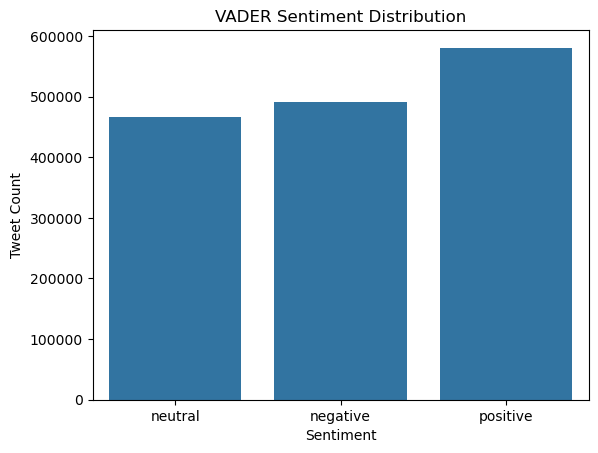

In [11]:
# Plotting Sentiment Distribution
sns.countplot(data=df_customer, x='vader_sentiment')
plt.title('VADER Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()


#### Insight
To beggin with the sentiment labelling, we have applied the VADER (Valence Aware Dictionary and sEntiment Reasoner), a lexcon and rule-based sentiment analysis tool. It was used on customer messages especifically, those where  'inbound' was equal (==) to 'True'. The VADER logic classifies  as positive if compound score is >= 0.05, negative  if it is <= -0.05 and neutral otherwise.

This labelling step is part of this projects' weak sepervision strategy, where we are goint to assign sentiment label to unlabelled customer messages, these labels will be later used directly for model training (ML and DL), compered with labels from transformer-based models like DistilBERT and refine with human review.

### DistilBERT

In [12]:
# Loading Pre-Trained DistilBERT
classifier = pipeline('sentiment-analysis', model = 'distilbert-base-uncased-finetuned-sst-2-english', framework = 'pt')

Device set to use mps:0


In [ ]:
# Applying DistilBERT Sentiment Classification On The Dataset

# Making sure all text is string
df_customer['clean_text'] = df_customer['clean_text'].astype(str)


def distilbert_sentiment_batch(texts, batch_size=128):
    result = []
    for i in tqdm(range(0, len(texts), batch_size), desc="DistilBERT Sentiment"):
        batch = texts[i: i + batch_size].tolist()
        outputs = classifier(batch)
        result.extend([output['label'].lower() for output in outputs])
    return result

# Splitting dataset into chunks
chunk_size = len(df_customer) // 4
chunks = [df_customer.iloc[i:i+chunk_size] for i in range(0, len(df_customer), chunk_size)]

# Applying the sentiment and saving each chunk
for idx, chunk in enumerate(chunks):
    print(f"\n Processing chunk {idx+1}/{len(chunks)}")
    chunk['distilbert_sentiment'] = distilbert_sentiment_batch(chunk['clean_text'])
    chunk.to_csv(f"distilbert_chunk_{idx+1}.csv", index=False)
    
# Recombining the chunks into a full dataset
df_customer = pd.concat([pd.read_csv(f"distilbert_chunk_{i+1}.csv") for i in range(len(chunks))], ignore_index=True)


In [14]:
# Loading the chunks
df_chunks = [pd.read_csv(f"distilbert_chunk_{i+1}.csv") for i in range(5)]

# Merging chunks
df_customer = pd.concat(df_chunks, ignore_index=True)

print(df_customer.columns)
print(df_customer[['clean_text', 'distilbert_sentiment']].head())

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id', 'conversation_id',
       'message_length', 'clean_text', 'vader_sentiment',
       'distilbert_sentiment'],
      dtype='object')
                                          clean_text distilbert_sentiment
0                  and how do you propose we do that             positive
1  i have sent several private messages and no on...             negative
2                                              i did             positive
3                      is the worst customer service             negative
4  you gonna magically change your connectivity f...             positive


In [16]:
# Saving the result
df_customer.to_csv("labelled_data.csv", index=False)
df_customer.to_pickle("labelled_data.pkl") 

In [ ]:
# Checking DistilBERT labelling
df_customer[['clean_text', 'distilbert_sentiment']].head(10)


,clean_text,distilbert_sentiment
0,and how do you propose we do that,positive
1,i have sent several private messages and no on...,negative
2,i did,positive
3,is the worst customer service,negative
4,you gonna magically change your connectivity f...,positive
5,since i signed up with yousince day 1,positive
6,yall lie about your great connection 5 bars lt...,negative
7,"whenever i contact customer support, they tell...",negative
8,would you like me to email you a copy of one s...,negative
9,i received this from your corporate office wou...,negative


#### Insight
To complement the sentiment labelling using VADER, we have also applied DistilBERT, a lightweight transformer-based language model fine-tuned for sentiment analysis (distilbert-base-uncased-finetuned-sst-2-english).

DistilBERT improves deep learnig and contextual embedding to classify messages as positive and negative with a higher level of semantic undestanding compared to a traditional lexicon-based approches.

We used DistilBERT with the objective of introduce a more context-aware perspective into the weak supervision strategy, this model has been applied to the same subset of customer message or 'inbound = true' and resulting predictions will be used to compare and potentially combine with the VADER labels to improve overall label quality.

This process is crutial for generating pseudo-lebels that will later be used for training supervised machine learning and deep learning models.

### RoBERTa

In [2]:
# Loading Pre-Treined RoBERTa 
roberta_classifier = pipeline("sentiment-analysis", model = "cardiffnlp/twitter-roberta-base-sentiment", framework = 'pt')

Device set to use mps:0


In [3]:
# Defining batch classification function
df_customer = pd.read_pickle("/Users/diegolemos/Masters/ML/CA2/labelled_data.pkl")
df_customer['clean_text'] = df_customer['clean_text'].astype(str)

def roberta_sentiment_batch(texts, batch_size=128):
    result = []
    for i in tqdm(range(0, len(texts), batch_size), desc="RoBERTa Sentiment"):
        batch = texts[i: i + batch_size].tolist()
        outputs = roberta_classifier(batch)
        result.extend([output['label'].lower() for output in outputs])
    return result

# Splitting in chuncks
chunk_size = len(df_customer) // 5
chunks = [df_customer.iloc[i:i+chunk_size].copy() for i in range(0, len(df_customer), chunk_size)]

# List of completed chunks, automatically detected
completed_chunks = [i + 1 for i in range(len(chunks)) if os.path.exists(f"roberta_chunk_{i+1}.csv")]

# Running and saving the chunks
for idx, chunk in enumerate(chunks):
    chunk_id = idx + 1
    if chunk_id in completed_chunks:
        print(f" Skipping already processed chunk {chunk_id}")
        continue

    print(f"\n Processing RoBERTa chunk {chunk_id}/{len(chunks)}")
    chunk['roberta_sentiment'] = roberta_sentiment_batch(chunk['clean_text'])
    chunk.to_csv(f"roberta_chunk_{idx+1}.csv", index=False)
    
# Recombining the chunks into a full dataset
df_roberta_chunks = [pd.read_csv(f"roberta_chunk_{chunk_id}.csv") for i in range(len(chunks))]
df_customer = pd.concat(df_roberta_chunks, ignore_index=True)

# Saving the update dataframe
df_customer.to_csv("labelled_data_with_roberta.csv", index=False)
df_customer.to_pickle("labelled_data_with_roberta.pkl")

 Skipping already processed chunk 1

 Processing RoBERTa chunk 2/6


RoBERTa Sentiment: 100%|██████████| 2403/2403 [1:33:49<00:00,  2.34s/it]



 Processing RoBERTa chunk 3/6


RoBERTa Sentiment: 100%|██████████| 2403/2403 [1:33:13<00:00,  2.33s/it]



 Processing RoBERTa chunk 4/6


RoBERTa Sentiment: 100%|██████████| 2403/2403 [1:36:31<00:00,  2.41s/it]



 Processing RoBERTa chunk 5/6


RoBERTa Sentiment: 100%|██████████| 2403/2403 [1:40:04<00:00,  2.50s/it]



 Processing RoBERTa chunk 6/6


RoBERTa Sentiment: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


#### Note
The file 'labelled_data_with_roberta.pkl' was not saved properly, so we will need to recover the RoBERTa labelling.

In [38]:
# Loading RoBERTa chunks
roberta_chunks = [pd.read_csv(f'roberta_chunk_{i+1}.csv') for i in range(6)]

# Concatenating in a full Dataframe
df_customer = pd.concat(roberta_chunks, ignore_index = True)

# Checking full dataset
print(f'Total rows after recombining: {len(df_customer)}')
print(f'RoBERTa unique labels: {df_customer['roberta_sentiment'].unique()}')

Total rows after recombining: 1537843
RoBERTa unique labels: ['label_1' 'label_0' 'label_2']


In [39]:
#  Mapping RoBERTa labels

# Normalizing text to lowercase
df_customer['roberta_sentiment'] = df_customer['roberta_sentiment'].astype(str).str.strip().str.lower()

# Mapping numeric labels to sentiment
map_label = {
    'label_0' : 'negative',
    'label_1' : 'neutral',
    'label_2' : 'positive' 
}

df_customer['roberta_sentiment'] = df_customer['roberta_sentiment'].map(map_label)

# Checking resilts
print(df_customer['roberta_sentiment'].value_counts(dropna = False))

roberta_sentiment
negative    722823
neutral     600990
positive    214030
Name: count, dtype: int64


In [40]:
# Saving final labelled dataset
df_customer.to_csv('labelled_data_with_roberta.csv', index = False)
df_customer.to_pickle('labelled_data_with_roberta.pkl')

In [41]:
# Checking RoBERTa labelling
df_customer[['clean_text', 'roberta_sentiment']].head(10)

,clean_text,roberta_sentiment
0,and how do you propose we do that,neutral
1,i have sent several private messages and no on...,negative
2,i did,neutral
3,is the worst customer service,negative
4,you gonna magically change your connectivity f...,neutral
5,since i signed up with yousince day 1,neutral
6,yall lie about your great connection 5 bars lt...,negative
7,"whenever i contact customer support, they tell...",negative
8,would you like me to email you a copy of one s...,neutral
9,i received this from your corporate office wou...,neutral


#### Insight
We have also used RoBERTa, another powerful transformer-based model that has been pre-trained on an extensive corpus of English text and is tailored for subsequent NLP tasks, to improve sentiment labeling even more, in particular, we employed a 'cardiffnlp/twitter-roberta-base-sentiment-based' sentiment classification pipeline.

RoBERTa performs exceptionally well on sentiment analysis tasks, especially when used for casual customer messages or social media. It is particularly well-suited for our dataset because of its pretraining on Twitter data, which improves its ability to capture subtleties, slang, and short-form language.

Label_0, label_1, and label_2 are the sentiment labels assigned by the RoBERTa classifier, these represent negative, neutral, and positive sentiments, respectively. Later, these were converted into labels that people could read.

In order expand our weak supervision approach, we employed RoBERTa as a complementary model in addition to VADER and DistilBERT. The objective was to increase label accuracy by utilizing its contextual and domain-aware knowledge. By comparing predictions from different models, inconsistencies can be found and more trustworthy pseudo-labels can be created for use in training machine learning and deep learning models later on.

### VADER VS DistilBERT VS RoBERTa Label Comparison

In [42]:
# Loading the combined dataframe
df = pd.read_pickle("labelled_data_with_roberta.pkl")
df[['vader_sentiment', 'distilbert_sentiment', 'roberta_sentiment']].head()

,vader_sentiment,distilbert_sentiment,roberta_sentiment
0,neutral,positive,neutral
1,negative,negative,negative
2,neutral,positive,neutral
3,negative,negative,negative
4,neutral,positive,neutral


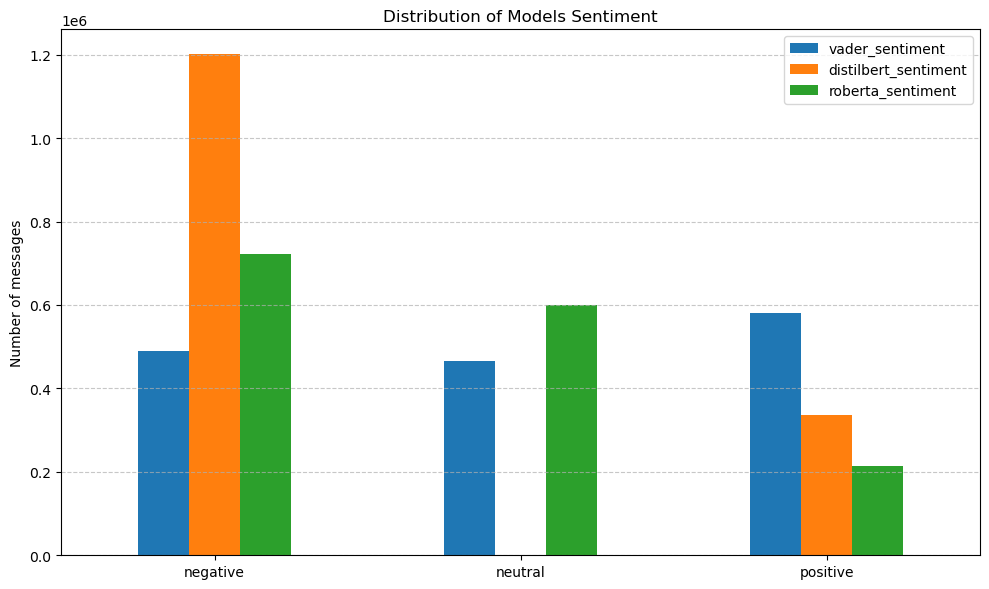

In [54]:
# Checking Models' Sentiment Distribution
label_counts = df_customer[['vader_sentiment', 'distilbert_sentiment', 'roberta_sentiment']].apply(pd.Series.value_counts)
label_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Models Sentiment')
plt.ylabel('Number of messages')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Insights from Sentiment Distributions

The above chart highlights how each model distributes labels across the dataset:

- VADER tends to assign more neutral labels due to its rule-based nature and lack of context awareness.
- DistilBERT and RoBERTa, as transformer models provide more context-sensitive outputs and show a more diverse distribution of positive and negative sentiments.
- The differences between the models reflect their underlying architecture and will influence how we combine their outputs in the merging strategy.


In [46]:
# Comparing models pairwise agreemen
def models_agreement(col1, col2):
    return (df_customer[col1] == df_customer[col2]).mean()

print('VADER vc DistilBERT: ', models_agreement('vader_sentiment', 'distilbert_sentiment'))
print("VADER vs RoBERTa:", models_agreement("vader_sentiment", "roberta_sentiment"))
print("DistilBERT vs RoBERTa:", models_agreement("distilbert_sentiment", "roberta_sentiment"))

VADER vc DistilBERT:  0.4505798056108458
VADER vs RoBERTa: 0.5749117432663803
DistilBERT vs RoBERTa: 0.5631160007881169


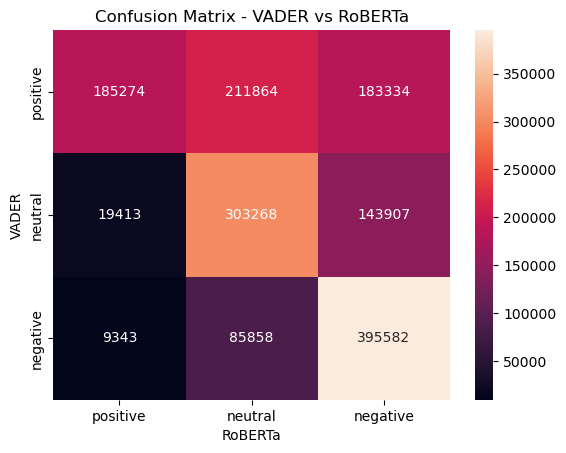

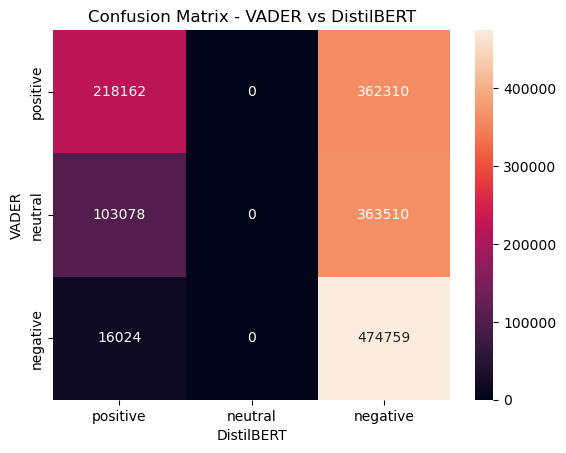

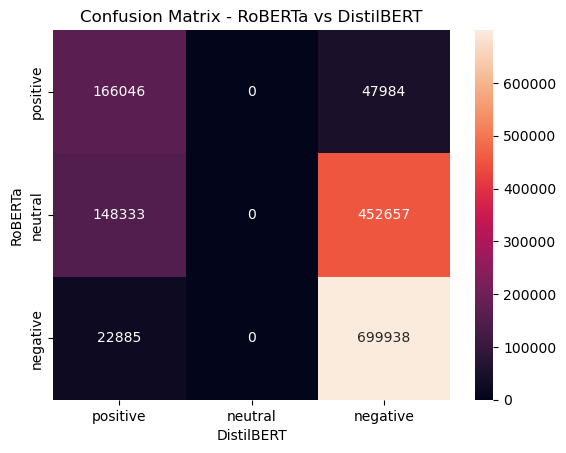

In [51]:
# Plotting Confusion Matrix VADER vs RoBERTa
conf = confusion_matrix(df_customer['vader_sentiment'], df_customer['roberta_sentiment'], labels=["positive", "neutral", "negative"])
sns.heatmap(conf, annot=True, fmt='d', xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("Confusion Matrix - VADER vs RoBERTa")
plt.xlabel("RoBERTa")
plt.ylabel("VADER")
plt.show()

# Plotting Confusion Matrix VADER vs DistilBERT
conf = confusion_matrix(df_customer['vader_sentiment'], df_customer['distilbert_sentiment'], labels=["positive", "neutral", "negative"])
sns.heatmap(conf, annot=True, fmt='d', xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("Confusion Matrix - VADER vs DistilBERT")
plt.xlabel("DistilBERT")
plt.ylabel("VADER")
plt.show()

# Plotting Confusion Matrix RoBERTa vs DistilBERT
conf = confusion_matrix(df_customer['roberta_sentiment'], df_customer['distilbert_sentiment'], labels=["positive", "neutral", "negative"])
sns.heatmap(conf, annot=True, fmt='d', xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("Confusion Matrix - RoBERTa vs DistilBERT")
plt.xlabel("DistilBERT")
plt.ylabel("RoBERTa")
plt.show()

#### Insight

The confusion matrix show how sentiment predictions differ between VADER, DistilBERT, and RoBERTa models.

- VADER vs RoBERTa: There’s significant disagreement, especially for the "neutral" class. VADER assigns more messages to "neutral", while RoBERTa tends to push them toward "positive" or "negative".
  
- VADER vs DistilBERT: Here too, there's a pattern where DistilBERT rarely assigns the "neutral" label, on this case, the model just assigned positives and negative, 0 neutrals,and VADER continues to lean heavily on "neutral".

- RoBERTa vs DistilBERT: These two models show more alignment compared to VADER, but there's still disagreement, especially in how RoBERTa spreads predictions across all three classes, while DistilBERT seems to avoid "neutral" entirely.

This comparation suggests that VADER, being a lexicon-based model, is more conservative, while DistilBERT and RoBERTa, being transformer-based, capture more nuanced sentiment but with less agreement on "neutral" cases. These insights will help inform the next step—how to merge these labels for supervised training.


In [52]:
# Disagreement Betwenn Models
disagreement = df_customer[
    (df_customer['vader_sentiment'] != df_customer['distilbert_sentiment']) |
    (df_customer['vader_sentiment'] != df_customer['roberta_sentiment']) |
    (df_customer['distilbert_sentiment'] != df_customer['roberta_sentiment'])
]

disagreement[['clean_text', 'vader_sentiment', 'distilbert_sentiment', 'roberta_sentiment']].sample(10)


,clean_text,vader_sentiment,distilbert_sentiment,roberta_sentiment
606405,NaN,neutral,positive,neutral
140219,NaN,neutral,positive,neutral
1212006,what list of channels would i get for 599??? i...,neutral,negative,negative
1407584,i just sent it,neutral,negative,neutral
848458,how soon after a return is delivered to your h...,neutral,negative,neutral
909078,"thanks for fixing, but the damage has been don...",negative,negative,positive
117019,"ok, os aviso en cualquier caso, gracias",positive,positive,neutral
1350398,it says everything is right im in the preview...,neutral,positive,positive
214119,i dont even know how to work me iphone 7 i w...,positive,negative,negative
568736,hallo \nauf microsoft apps auf ipad pro kann ...,neutral,negative,neutral


#### Next Steps

With sentiment labels generated from three different models, we are ready to proceed to the 'merging step', where we will apply a strategy to create a single, unified label column. This will serve as the ground truth for model training.

After that, we will:
- Train classical machine learning models such as SVM and Random Forest
- Train a deep learning model, in the case the model will be BiLSTM
- Compare their performance
- Use metrics like accuracy, F1-score, and AUC to evaluate results


### Merging Model's Label

In [5]:
# Merging labels
def smart_merge(row):
    votes = [row['vader_sentiment'], row['distilbert_sentiment'], row['roberta_sentiment']]
    count = Counter(votes)
    
    # Case 1: All 3 agree
    if len(count) == 1:
        return votes[0]
    
    # Case 2: RoBERTa matches one of the others — trust RoBERTa
    if row['roberta_sentiment'] == row['vader_sentiment'] or row['roberta_sentiment'] == row['distilbert_sentiment']:
        return row['roberta_sentiment']
    
    # Case 3: All different — fall back to majority vote
    return count.most_common(1)[0][0]

# Applying it
df_customer['final_label'] = df_customer.apply(smart_merge, axis=1)


In [6]:
# Saving final dataset with the final label
df_customer.to_pickle("labelled_data_final.pkl")
df_customer.to_csv("labelled_data_final.csv", index=False)


#### Hybrid Merging Strategy for Final Labels

To create a reliable target variable for model training, we merged the outputs of VADER, DistilBERT, and RoBERTa using a hybrid voting strategy:

- If all three models agree, their label is assigned directly.
- If two models agree and RoBERTa is one of them, we trust RoBERTa and use that label.
- If all three disagree, we fallback to majority voting.

This approach ensures that we leverage the robustness of transformer-based models like RoBERTa, while still respecting consensus when it occurs. It balances reliability and coverage, making it suitable for weakly supervised learning.


In [7]:
# Checking Final Distribution
df_customer['final_label'].value_counts()

final_label
negative    797863
positive    424513
neutral     315467
Name: count, dtype: int64

In [8]:
# Checking class imbalance in the final merged labels
print("Final label distribution (%):")
print(df_customer['final_label'].value_counts(normalize=True) * 100)

Final label distribution (%):
final_label
negative    51.881954
positive    27.604443
neutral     20.513602
Name: proportion, dtype: float64


#### Class Imbalance Check

The distribution of final labels in percentage helps identify class imbalance. If one class such as neutral dominates, it might skew model performance.

We may need to use class weighting or oversampling techniques during training to address this.


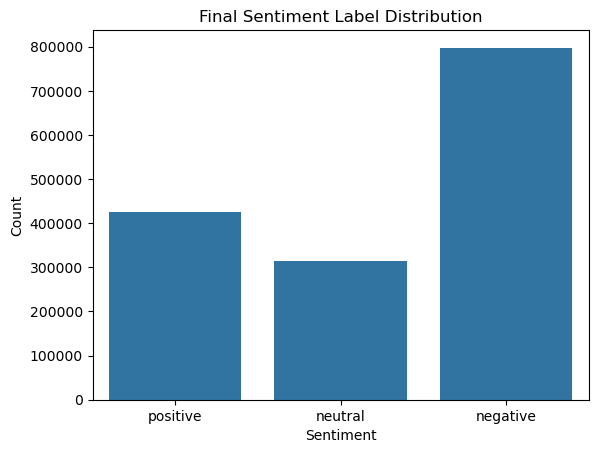

In [9]:
# Plotting final labels
sns.countplot(data=df_customer, x='final_label', order=['positive', 'neutral', 'negative'])
plt.title('Final Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

#### Label Distribution Insight

The bar chart comparing label distribution of the models and final labels shows that:

- VADER tends to predict more neutral sentiments due to its rule-based nature.
- DistilBERT avoids the neutral class more often and leans toward binary classification like positive and negative.
- RoBERTa outputs are more balanced and contextually aware, and the final label distribution reflects a reasonable mix of sentiments.

Understanding this distribution is important for preparing training data and evaluating class balance.


In [10]:
# Comparing final label
for model in ['vader_sentiment', 'distilbert_sentiment', 'roberta_sentiment']:
    agreement = (df_customer['final_label'] == df_customer[model]).mean()
    print(f'Agreement with {model}: {agreement:.2%}')

Agreement with vader_sentiment: 78.71%
Agreement with distilbert_sentiment: 66.34%
Agreement with roberta_sentiment: 78.78%


#### Agreement with Final Label

The following agreement scores show how frequently each model's prediction matched the final label derived by the hybrid merging strategy:

- VADER: 78.71%
- DistilBERT: 66.34%
- RoBERTa: 78.78%

This confirms that RoBERTa aligns more closely with the final label strategy, as expected, since it is prioritized during partial agreement.


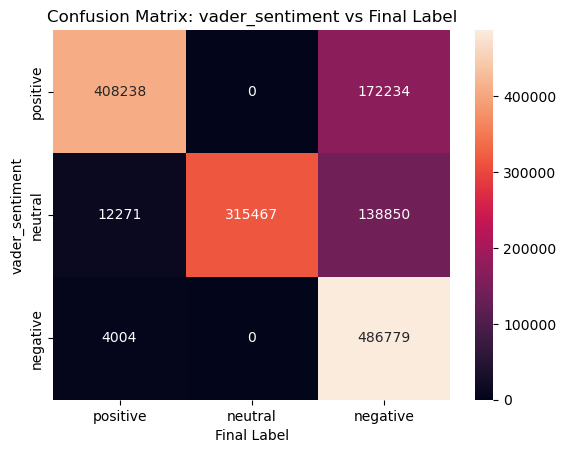

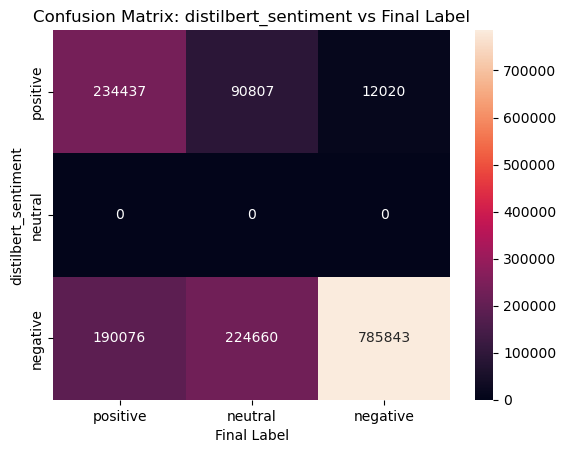

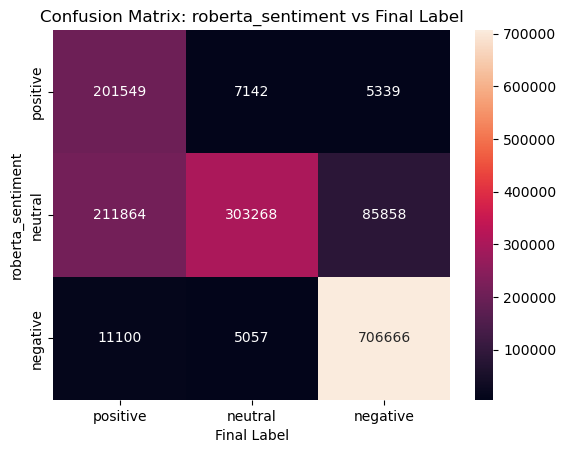

In [11]:
# Plotting confision matrix
models = ['vader_sentiment', 'distilbert_sentiment', 'roberta_sentiment']
for model in models:
    cm = confusion_matrix(df_customer[model], df_customer['final_label'], labels=['positive', 'neutral', 'negative'])
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
    plt.title(f'Confusion Matrix: {model} vs Final Label')
    plt.xlabel('Final Label')
    plt.ylabel(model)
    plt.show()

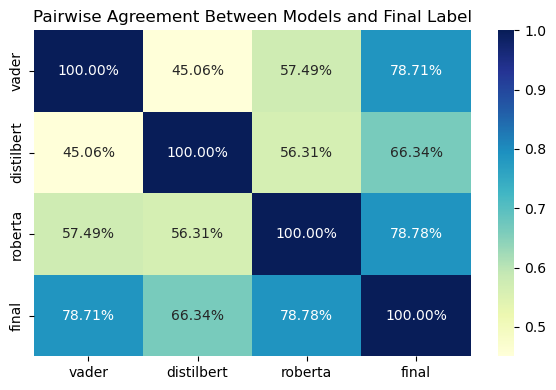

In [12]:
# Pairwise agreement matrix
agreement_matrix = pd.DataFrame(index=['vader', 'distilbert', 'roberta', 'final'], columns=['vader', 'distilbert', 'roberta', 'final'])

for col1 in agreement_matrix.columns:
    for col2 in agreement_matrix.index:
        col1_label = 'final_label' if col1 == 'final' else f'{col1}_sentiment'
        col2_label = 'final_label' if col2 == 'final' else f'{col2}_sentiment'
        agreement_matrix.loc[col2, col1] = (df_customer[col1_label] == df_customer[col2_label]).mean()

agreement_matrix = agreement_matrix.astype(float)

plt.figure(figsize=(6, 4))
sns.heatmap(agreement_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("Pairwise Agreement Between Models and Final Label")
plt.tight_layout()
plt.show()


#### Insights

To evaluate the agreement and reliability of each weak labeling model, we compared their predictions against the final consensus label using confusion matrix.

VADER shows a strong alignment with the final label on the positive and negative classes, with particularly high agreement on negative examples. However, it often misclassifies positive samples as neutral, suggesting a tendency toward conservative (neutral) classification.

DistilBERT clearly favors binary classification, positive and negative and lacks a meaningful neutral category, likely due to the SST-2 dataset it was fine-tuned on. This limits its nuance in handling moderately toned or ambiguous messages.

RoBERTa displays a balanced spread across all three sentiment classes showing the highest agreement with the final label, and maintains distinguishable boundaries between sentiments. RoBERTa performs particularly well in identifying neutral messages, where VADER and DistilBERT struggle.

In summary, RoBERTa is the most consistent with the consensus labels across all sentiment categories, As DistilBERT performs well on polarized messages like positive and negative, but lacks middle-ground handling. Finally, VADER, while lightweight and interpretable, tends to skew toward neutrality, which might reduce effectiveness in highly subjective messages.

These findings validate the merit of using a majority-vote strategy to build the final_label, leveraging each model’s strengths to create a robust training target.


#### Manual Review – Gold Standard Validation

As outlined in the original project proposal, the manual review stage aimed to validate a random sample of 5,000 support messages using human annotation. However, due to time constraints and the scope of the project, a subset of 500 messages was reviewed instead.

For each message, the VADER, DistilBERT, and RoBERTa sentiment predictions will be compared to the final merged label. Human judgment will be used to assess whether the final label is correct. If not, a new manual_label will be assigned.

This manual review serves two purposes:
- It acts as a gold standard benchmark for evaluating model performance.
- It identifies edge cases where models fail, such as sarcasm, ambiguity, or conversational context.

The review will be performed offline in a CSV file and reloaded for comparison and analysis.

In [13]:
# Getting a sample of 5,000 messages for manual review
sample_df = df_customer.sample(n=5000, random_state=42)

# Saving for external annotation
sample_df.to_csv("manual_review_sample.csv", index=False)


In [14]:
# Loading dataframe with the manual review
manual_df = pd.read_csv("manual_review_sample.csv")

# Cheacking head
manual_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,message_length,clean_text,vader_sentiment,distilbert_sentiment,roberta_sentiment,final_label,manual_label
0,34581.0,123491.0,True,Wed Nov 01 14:03:55 +0000 2017,@AppleSupport Basically for a chat to be opene...,34582,34579.0,34579.0,145.0,basically for a chat to be opened from call lo...,neutral,negative,neutral,neutral,neutral
1,246537.0,174558.0,True,Thu Oct 05 14:08:30 +0000 2017,@AppleSupport iOS 11.02 and Watchos4.0: No ico...,"246,536,246,538",NaN,246537.0,164.0,ios 1102 and watchos40 no icon for twitter not...,negative,negative,negative,negative,negative
2,101228.0,138151.0,True,Thu Nov 30 17:14:45 +0000 2017,"Dear god not again,@AppleSupport https://t.co/...","101,227,101,229",NaN,101228.0,56.0,"dear god not again,",positive,negative,negative,negative,negative
3,1351215.0,435088.0,True,Mon Oct 16 13:33:22 +0000 2017,@ATVIAssist Hi there! If I buy Call of Duty WW...,1351214,NaN,1351215.0,119.0,hi there! if i buy call of duty wwii on steam ...,neutral,negative,neutral,neutral,neutral
4,228814.0,170570.0,True,Thu Oct 05 08:01:11 +0000 2017,Hi @Safaricom_Care why can't I pay my my Dstv ...,228812,NaN,228814.0,79.0,hi why cant i pay my my dstv texts says the o...,positive,negative,negative,negative,negative


#### Evaluation of Manual Labelling vs Weack Supervised Final Labels

In [ ]:
# Keeping only the rows where manual_label is not null
validated_df = manual_df[manual_df['manual_label'].notnull()]
print(f"Number of manually labelled samples: {len(validated_df)}")

Number of manually labeled samples: 500


In [22]:
# Save final manually annotated evaluation dataset
manual_df.to_csv("manual_label_evaluation_dataset.csv", index=False)

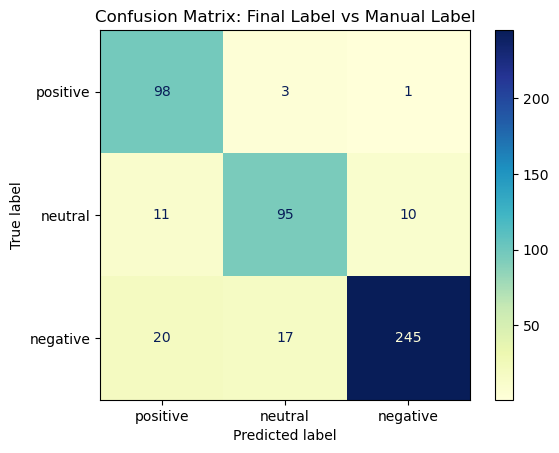

In [18]:
# Generating Confusion Matrix
cm = confusion_matrix(validated_df['manual_label'], validated_df['final_label'], labels=['positive', 'neutral', 'negative'])

# Plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'neutral', 'negative'])
disp.plot(cmap='YlGnBu')
plt.title("Confusion Matrix: Final Label vs Manual Label")
plt.show()

In [21]:
# Printing report
print("Classification Report:")
print(classification_report(validated_df['manual_label'], validated_df['final_label'], digits=3))

# Printting Acuracy
accuracy = accuracy_score(validated_df['manual_label'], validated_df['final_label'])
print(f"Overall Accuracy: {accuracy:.2%}")

Classification Report:
              precision    recall  f1-score   support

    negative      0.957     0.869     0.911       282
     neutral      0.826     0.819     0.823       116
    positive      0.760     0.961     0.848       102

    accuracy                          0.876       500
   macro avg      0.848     0.883     0.861       500
weighted avg      0.886     0.876     0.878       500

Overall Accuracy: 87.60%


#### Manual Review and Evaluation Summary
A manual assessment was carried out to confirm the quality of sentiment labels produced under weak supervision, as specified in the project proposal. Due to time restrictions, the proposal's initial recommendation of examining 5,000 samples was lowered to 500 messages. Even so, the sample was sufficiently representative to assess the final labels' quality across all sentiment classes.

The final label for each message, which was determined by combining the predictions of VADER, DistilBERT, and RoBERTa, was compared against a label that was manually assigned. This contributed to the creation of a gold standard benchmark.

##### Results Summary
The analysis revealed that the model performed particularly well in predicting negative sentiment. Out of 282 negative messages in the manual review, 245 were correctly identified, resulting in strong performance metrics.

For neutral messages, the model correctly labeled 95 out of 116 cases. While reasonably accurate, this category showed some ambiguity, with occasional misclassifications into positive or negative.

Positive sentiment showed high recall, with 98 out of 102 positive messages correctly identified. However, the model's precision for positive sentiment was lower, indicating some misclassifications from other classes into positive. We believe that it may be an issue when the message written is ambiguous, when a person say something but means another thing, what is usully understood by humans but not by the models.

Overall, the classification metrics were strong:

The model achieved an overall accuracy of 87.6%.

The F1-score for each class was:

Negative: 0.91

Neutral: 0.82

Positive: 0.85

The macro-averaged F1-score was 0.86, and the weighted average F1-score was 0.88.

##### Key Insights
High Reliability on Negative Sentiment: The model consistently identifies negative messages with high precision and recall, making this its most reliable classification. This is important in customer support, where negative messages may require urgent attention and shows the customer dissaatisfaction.

Challenges in Neutral Classification: Neutral sentiment continues to be the most difficult to classify accurately. The results suggest occasional confusion between neutral and both other classes, likely due to subtle or ambiguous tone in the text.

Cautious but Effective Positive Sentiment Detection: While the model is effective at detecting positive messages when they exist (high recall), it is slightly overconfident in some cases, leading to lower precision. This could stem from misinterpreting sarcasm, enthusiasm, or polite dissatisfaction.

#### Conclusion
Reliable sentiment analysis at scale was made possible in large part by the labeling method used throughout this project. Even without human-annotated data, we were able to create a final sentiment label for every message by utilizing a weak supervision technique and combining predictions from VADER, DistilBERT, and RoBERTa.

In order to ensure that edge cases and confusing messages were thoughtfully resolved, this approach was carefully developed to strike a balance between majority voting logic and trust in sophisticated language models (favoring RoBERTa where conflicts occurred).

To validate this approach, a manual review of 500 messages was conducted, simulating a gold standard benchmark. Each message's final label was compared with a human judgment. The results showed:

87.6% overall agreement between final labels and human-assigned manual labels.

Strong performance across all sentiment classes, especially for negative and positive messages.

Slight room for improvement in detecting neutral sentiment — a common challenge in sentiment classification due to its nuanced nature.

Together, this confirms that the labeling pipeline is effective, accurate, and scalable, providing a solid foundation for model training and evaluation.

The successful completion of this stage validates the entire labeling process as not only technically sound but also practically aligned with human expectations. It ensures the integrity of the dataset, boosts confidence in upcoming Machine Learning and Deap Learning models trained on it, and fulfills the quality standards outlined in the project proposal.

